In [ ]:
import pandas as pd
import numpy as np
import random
import os

def load_data(timestamp_files):
    """
    Loads the option data for each timestamp from the provided CSV files and ensures the correct data types.
    """
    data = {}
    for t, file in enumerate(timestamp_files):
        data[t] = pd.read_csv(file)  # Load data from CSV file

        # Ensure 'Close  ' and 'Underlying Value' columns are numeric (convert to float)
        data[t]['Close'] = pd.to_numeric(data[t]['Close'], errors='coerce')
        data[t]['Underlying Value'] = pd.to_numeric(data[t]['Underlying Value'], errors='coerce')

        # Add a 'used' column to track if an option is used in a time series
        data[t]['used'] = False

    return data

def select_next_option(current_price, next_timestamp_data, percentage_range=(-0.01, 0.05)):
    """
    Selects the next option randomly within a specified price range.

    Parameters:
    - current_price: The current option price in the time series.
    - next_timestamp_data: DataFrame of the next timestamp options.
    - percentage_range: Tuple representing the percentage range (min, max) to limit selection.

    Returns:
    - selected_option: The selected option (if any) within the range.
    """
    min_price = current_price * (1 + percentage_range[0])
    max_price = current_price * (1 + percentage_range[1])

    # Filter next timestamp data for options within the range and not yet used
    candidates = next_timestamp_data[
        (next_timestamp_data['Close'] >= min_price) &
        (next_timestamp_data['Close'] <= max_price) &
        (next_timestamp_data['used'] == False)
    ]

    if not candidates.empty:
        selected_option = candidates.sample(n=1)  # Randomly select one from the filtered options
        return selected_option.iloc[0]
    else:
        return None  # No option found in the range



def create_time_series(data, percentage_range=(-0.01, 0.05)):
    """
    Creates time series by connecting options across timestamps.

    Parameters:
    - data: Dictionary of DataFrames for each timestamp.
    - percentage_range: Range of price movement allowed for selecting the next option.

    Returns:
    - time_series_list: List of time series created.
    - underlying_series_list: List of corresponding underlying value time series.
    - time_to_maturity_series_list: List of corresponding time-to-maturity series.
    - strike_price_series_list: List of corresponding strike price series.
    """
    time_series_list = []
    underlying_series_list = []
    time_to_maturity_series_list = []
    strike_price_series_list = []

    for t in range(len(data) - 1):  # Iterate through timestamps
        for i, option in data[t].iterrows():
            if not option['used']:  # If option is not used in any time series
                time_series = [option['Close']]  # Start new time series for option prices
                underlying_series = [option['Underlying Value']]  # Start new series for underlying values
                time_to_maturity_series = [option['Time to Maturity']]  # Start new series for time to maturity
                strike_price_series = [option['Strike Price']]  # Start new series for strike price
                data[t].at[i, 'used'] = True  # Mark as used

                current_price = option['Close']
                current_underlying = option['Underlying Value']
                current_time_to_maturity = option['Time to Maturity']
                current_strike_price = option['Strike Price']

                for next_t in range(t+1, len(data)):
                    next_option = select_next_option(current_price, data[next_t], percentage_range)
                    if next_option is not None:
                        time_series.append(next_option['Close'])
                        underlying_series.append(next_option['Underlying Value'])
                        time_to_maturity_series.append(next_option['Time to Maturity'])
                        strike_price_series.append(next_option['Strike Price'])
                        current_price = next_option['Close']
                        current_underlying = next_option['Underlying Value']
                        current_time_to_maturity = next_option['Time to Maturity']
                        current_strike_price = next_option['Strike Price']
                        data[next_t].at[next_option.name, 'used'] = True  # Mark as used
                    else:
                        break  # No more options within range, stop this time series

                time_series_list.append(time_series)  # Save the constructed time series
                underlying_series_list.append(underlying_series)  # Save the corresponding underlying series
                time_to_maturity_series_list.append(time_to_maturity_series)  # Save the time to maturity series
                strike_price_series_list.append(strike_price_series)  # Save the strike price series

    return time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list

def extend_time_series(time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list, target_length=75):
    """
    Extends the time series to a target length by inserting random values.

    Parameters:
    - time_series_list: List of time series to be extended.
    - underlying_series_list: List of corresponding underlying value time series.
    - time_to_maturity_series_list: List of corresponding time to maturity series.
    - strike_price_series_list: List of corresponding strike price series.
    - target_length: The desired final length of each time series.

    Returns:
    - extended_series_list: List of extended time series.
    - extended_underlying_list: List of extended underlying value series.
    - extended_time_to_maturity_list: List of extended time to maturity series.
    - extended_strike_price_list: List of extended strike price series.
    """
    extended_series_list = []
    extended_underlying_list = []
    extended_time_to_maturity_list = []
    extended_strike_price_list = []

    for ts, us, tm, sp in zip(time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list):
        if len(ts) >= 7:
            while len(ts) < target_length:
                # Randomly select two distinct points in the time series
                idx1, idx2 = random.sample(range(len(ts)), 2)
                idx1, idx2 = sorted([idx1, idx2])  # Ensure idx1 < idx2

                # Get the values at these points
                val1 = ts[idx1]
                val2 = ts[idx2]

                # Get the underlying values at these points
                spot1 = us[idx1]
                spot2 = us[idx2]

                # Get the time to maturity at these points
                time1 = tm[idx1]
                time2 = tm[idx2]

                # Get the strike prices at these points
                strike1 = sp[idx1]
                strike2 = sp[idx2]

                # Determine the range for the new option price value
                min_value = min(val1, val2) * 0.98  # -2% of the smaller one
                max_value = max(val1, val2) * 1.02  # +2% of the greater one

                # Determine the range for the new underlying value
                min_underlying_value = min(spot1, spot2) * 0.98  # -2% of the smaller spot price
                max_underlying_value = max(spot1, spot2) * 1.02  # +2% of the greater spot price

                # Determine the range for the new time to maturity
                new_time_to_maturity = random.uniform(min(time1, time2), max(time1, time2))

                # Determine the range for the new strike price
                min_strike_price = min(strike1, strike2) * 0.98  # -2% of the lower strike price
                max_strike_price = max(strike1, strike2) * 1.02  # +2% of the higher strike price
                new_strike_price = random.uniform(min_strike_price, max_strike_price)

                # Generate random values in the respective ranges
                new_value = random.uniform(min_value, max_value)
                new_underlying_value = random.uniform(min_underlying_value, max_underlying_value)

                # Insert the new values at a random position between idx1 and idx2
                insert_position = random.randint(idx1 + 1, idx2)  # Must be between the two points
                ts.insert(insert_position, new_value)
                us.insert(insert_position, new_underlying_value)
                tm.insert(insert_position, new_time_to_maturity)
                sp.insert(insert_position, new_strike_price)

            extended_series_list.append(ts)  # Append the extended series
            extended_underlying_list.append(us)  # Append the extended underlying series
            extended_time_to_maturity_list.append(tm)  # Append the extended time to maturity series
            extended_strike_price_list.append(sp)  # Append the extended strike price series

    return extended_series_list, extended_underlying_list, extended_time_to_maturity_list, extended_strike_price_list

# Example usage:

# Generate file paths for all 28 timestamps
timestamp_files = [f'/content/timestamp_{i}.csv' for i in range(24)]

# Load the data from the files
data = load_data(timestamp_files)

# Create the time series with the heuristic range of -5% to +15%
time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list = create_time_series(data, percentage_range=(-0.01, 0.05))

# Extend the time series
extended_time_series, extended_underlying_series, extended_time_to_maturity_series, extended_strike_price_series = extend_time_series(
    time_series_list, underlying_series_list, time_to_maturity_series_list, strike_price_series_list)

# Output the generated time series and corresponding underlying, time-to-maturity, and strike-price series
for idx, (ts, us, tm, sp) in enumerate(zip(extended_time_series, extended_underlying_series, extended_time_to_maturity_series, extended_strike_price_series)):
    print(f"Time Series {idx+1}: {ts}")
    print(f"Underlying Value Series {idx+1}: {us}")
    print(f"Time to Maturity Series {idx+1}: {tm}")
    print(f"Strike Price Series {idx+1}: {sp}")


Time Series 1: [8007.95, 8007.95, 7897.459881866155, 8007.95, 8007.95, 8123.125138535963, 8007.95, 8007.95, 7921.382931035784, 7917.8736586377545, 8102.012448553727, 7978.628032707639, 7779.4335943459255, 7949.269973734214, 8035.807588842683, 8108.696358921243, 8055.796735855601, 7782.824267781797, 7863.490868289448, 8016.742244859836, 7888.531568080703, 7989.3527256611205, 7911.722165071625, 7906.265685335574, 7869.70900110945, 8036.5255789884895, 8157.372850088407, 8070.8117835304, 7935.1721180197965, 7968.229992639761, 7913.081683531897, 7960.702733767003, 8069.560510602794, 8099.367574883003, 8164.226687868637, 7939.798712282632, 8169.707906767268, 8082.725140047873, 7926.343697896586, 8059.139354272855, 7964.716018718418, 7819.888401926702, 7878.136925379255, 7822.52111697717, 8027.959245141361, 7941.672445371637, 8026.866538670283, 8007.95, 8007.95, 7903.326534665118, 7720.965190568111, 7917.128746171344, 8055.496917734566, 7904.793581058705, 8010.022485704059, 8072.873973824417,

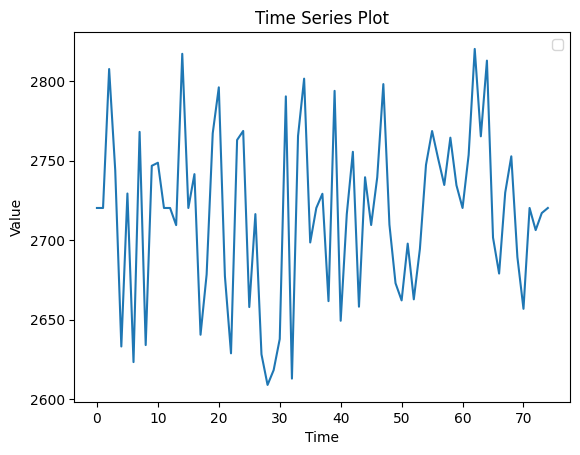

In [ ]:
# prompt: plot all of these time series together

import matplotlib.pyplot as plt

plt.plot(extended_time_series[22])

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Plot")
plt.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
!pip install tsfel
import tsfel  # Time Series Feature Extraction Library

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.0 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
def generate_heston_data(n_samples=len(extended_time_series), time_steps=100):

    params = np.zeros((n_samples, 5))  # alpha, eta, nu, sigma_nu, rho

    # Randomized parameter generation for Heston model
    for i in range(n_samples):
        alpha = np.random.uniform(0.1, 1)  # keep same range
        eta = np.random.uniform(0.01, 0.05)  # reduced range and magnitude
        nu = np.random.uniform(0.01, 0.05)  # reduced range and magnitude
        sigma_nu = np.random.uniform(0.1, 0.2)  # tighter range
        rho = np.random.uniform(-1, 0.2)  # more negative, avoiding extremes
        params[i] = [alpha, eta, nu, sigma_nu, rho]

        # Generate a time-series path for the Heston model (simplified)

    return params

params = generate_heston_data()

X_train, X_test, time_train, time_test, underlying_train, underlying_test,strike_train, strike_test, params_train, params_test = train_test_split(extended_time_series, extended_time_to_maturity_series, extended_underlying_series, extended_strike_price_series, params, test_size=0.2, random_state=42)

# Advanced Feature Extraction using TSFEL (Time Series Feature Extraction Library)
cfg = tsfel.get_features_by_domain("statistical")
X_train_features = tsfel.time_series_features_extractor(cfg, X_train)
X_test_features = tsfel.time_series_features_extractor(cfg, X_test)


<ipython-input-7-10f32074ba4e>:24: UserWarning: Using default sampling frequency set in configuration file.
  X_train_features = tsfel.time_series_features_extractor(cfg, X_train)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-7-10f32074ba4e>:25: UserWarning: Using default sampling frequency set in configuration file.
  X_test_features = tsfel.time_series_features_extractor(cfg, X_test)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# prompt: appropriately scale these features as they are very large

from sklearn.preprocessing import StandardScaler

# Assuming X_train_features and X_test_features are your feature matrices
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [ ]:
def build_deeponet():
    # Branch network hyperparameters
    branch_neurons_1 = 128
    branch_neurons_2 = 64
    branch_dropout = 0.3

    # Trunk network hyperparameters
    trunk_neurons_1 = 64

    # Branch Network
    branch_input = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(branch_neurons_1, activation='relu')(branch_input)
    x = Dropout(branch_dropout)(x)
    x = Dense(branch_neurons_2, activation='relu')(x)
    x = Dropout(branch_dropout)(x)
    branch_model = Model(branch_input, x)

    # Trunk Network
    trunk_input = Input(shape=(1,))
    x = Dense(trunk_neurons_1, activation='relu')(trunk_input)
    trunk_model = Model(trunk_input, x)

    # Combine branch and trunk outputs
    combined = concatenate([branch_model.output, trunk_model.output])
    final_output = Dense(128, activation='relu')(combined)
    final_output = Dropout(branch_dropout)(final_output)

    # Output layer: predicting 5 Heston parameters
    final_output = Dense(5, activation='linear')(final_output)

    # Build and compile the model
    model = Model([branch_model.input, trunk_model.input], final_output)

    # Add gradient clipping for stability
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0), loss='mse')

    return model


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]


In [ ]:
def safe_model_fit(model, X_train, params_train, callbacks):
    try:
        history = model.fit(
            [X_train_scaled, np.ones((X_train_scaled.shape[0], 1))], params_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            callbacks=callbacks
        )
        return history
    except Exception as e:
        print(f"Model fitting failed with error: {e}")
        return None


def ensemble_models(models, X_test_scaled):
    preds = np.zeros((len(X_test_scaled), 5))  # 5 parameters to predict
    for model in models:
        preds += model.predict([X_test_scaled, np.ones((X_test_scaled.shape[0], 1))])
    return preds / len(models)  # Average predictions


In [ ]:
ensemble = []
for _ in range(5):  # Build 5 models with slight variations
    model = build_deeponet()
    safe_model_fit(model, X_train, params_train, callbacks)
    ensemble.append(model)

# Perform ensemble prediction
ensemble_predictions = ensemble_models(ensemble, X_test_scaled)

# Evaluate ensemble model (for illustration, compare against actual test params)
ensemble_loss = np.mean((ensemble_predictions - params_test) ** 2)
print(f'Ensemble Model MSE: {ensemble_loss}')


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - loss: 0.2180 - val_loss: 0.1391 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1621 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1237 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1030 - val_loss: 0.0588 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0916 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1017 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0789 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0728 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0643 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Ensemble Model MSE: 0.09775609200617516


MSE for each parameter:
alpha: 0.2702500287676935
eta: 0.0021438468134741253
nu: 0.003032200378020289
sigma_nu: 0.014114419681432587
rho: 0.1992399643902552

Example 1:
Predicted Parameters: [ 0.21081252 -0.02114887  0.00316178  0.02958712 -0.10818715]
True Parameters: [0.97489999 0.04661259 0.0104474  0.18399939 0.04736256]

Example 2:
Predicted Parameters: [ 0.1618204   0.05700209 -0.06798691  0.18408965 -0.21297358]
True Parameters: [ 0.39611064  0.04493405  0.01955569  0.1632178  -0.93175876]

Example 3:
Predicted Parameters: [ 0.20179142 -0.00346291  0.0066142   0.0364311  -0.12162675]
True Parameters: [ 0.92943657  0.04947253  0.04200032  0.19726709 -0.71352977]

Example 4:
Predicted Parameters: [ 0.16878828 -0.05039652 -0.03369523  0.04077715 -0.08229502]
True Parameters: [ 0.49559286  0.03335083  0.04589148  0.17503794 -0.86997838]

Example 5:
Predicted Parameters: [ 2.47108733e-01 -8.60109925e-05 -4.80271280e-02  5.17089214e-02
 -1.62112543e-01]
True Parameters: [ 0.89061876  

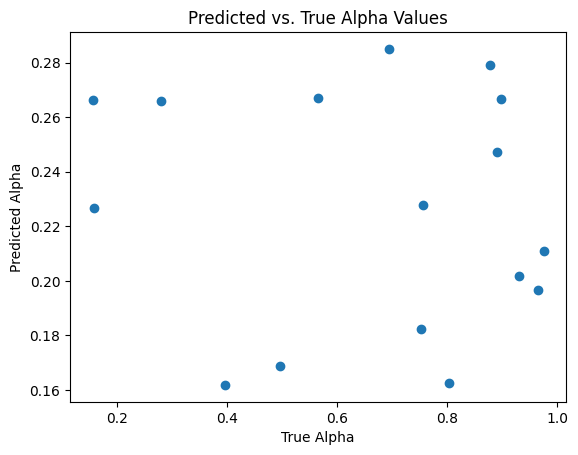

In [ ]:
mse_per_parameter = np.mean((ensemble_predictions - params_test) ** 2, axis=0)

# Print the MSE for each parameter
print("MSE for each parameter:")
parameter_names = ['alpha', 'eta', 'nu', 'sigma_nu', 'rho']
for i, mse in enumerate(mse_per_parameter):
    print(f"{parameter_names[i]}: {mse}")


# Optionally, you can also print some example predictions and their corresponding true values
for i in range(len(ensemble_predictions)):  # Print results for the first 5 test examples
    print(f"\nExample {i+1}:")
    print("Predicted Parameters:", ensemble_predictions[i])
    print("True Parameters:", params_test[i])

# Example:  Visualize the predicted vs. true values for a specific parameter (e.g., alpha)
plt.scatter(params_test[:, 0], ensemble_predictions[:, 0])  # alpha vs. predicted alpha
plt.xlabel("True Alpha")
plt.ylabel("Predicted Alpha")
plt.title("Predicted vs. True Alpha Values")
plt.show()

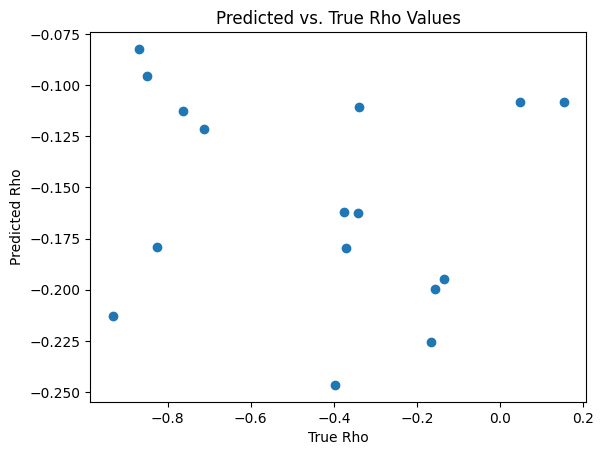

In [ ]:
plt.scatter(params_test[:, 4], ensemble_predictions[:, 4])  # alpha vs. predicted alpha
plt.xlabel("True Rho")
plt.ylabel("Predicted Rho")
plt.title("Predicted vs. True Rho Values")
plt.show()

In [ ]:
import random
import numpy as np

random_index = random.randint(0, len(X_test) - 1)
random_time_series = X_test[random_index]
time_to_maturities = time_test[random_index]
random_underlying = underlying_test[random_index]
random_strike = strike_test[random_index]
predicted_params = ensemble_predictions[random_index]
alpha, eta, nu, sigma_nu, rho = predicted_params


In [ ]:
n = len(random_time_series)
data = []
for i in range(n):
    d = {'price': random_time_series[i], 'S0': random_underlying[i], 'K': random_strike[i], 'tau': time_to_maturities[i]}
    data.append(d)

print(data)


[{'price': 6063.45, 'S0': 52270.65, 'K': 46500.0, 'tau': 0.0931506849315068}, {'price': 6063.45, 'S0': 52278.9, 'K': 46500.0, 'tau': 0.0904109589041095}, {'price': 6063.45, 'S0': 52455.9, 'K': 46500.0, 'tau': 0.0821917808219178}, {'price': 6063.45, 'S0': 52396.8, 'K': 46500.0, 'tau': 0.0794520547945205}, {'price': 5933.390244633778, 'S0': 52829.02003376517, 'K': 46974.069557872164, 'tau': 0.06778127885722231}, {'price': 6158.382160485731, 'S0': 51496.13598671408, 'K': 46761.7008285971, 'tau': 0.06484879663668286}, {'price': 5999.969383190785, 'S0': 52430.17342701813, 'K': 45662.75144847192, 'tau': 0.06611857974699442}, {'price': 6039.052709345924, 'S0': 52274.26778417227, 'K': 46087.50971734205, 'tau': 0.05574273657606974}, {'price': 5934.546682377128, 'S0': 53212.285890676445, 'K': 46375.98613310732, 'tau': 0.06130437634504255}, {'price': 6067.450576387064, 'S0': 52513.70230037745, 'K': 47819.25031192754, 'tau': 0.06813029441037736}, {'price': 6063.45, 'S0': 52620.7, 'K': 46500.0, 'ta

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import math

# Heston model pricer and characteristic function definitions
# def heston_characteristic_function(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum):
#     """
#     Compute the characteristic function for the Heston model.
#     """
#     i = complex(0, 1)
#     x = np.log(S0)
#     if Pnum == 1:
#         u = 0.5
#         b = kappa - rho * sigma
#     else:
#         u = -0.5
#         b = kappa

#     d = np.sqrt((rho * sigma * i * phi - b)**2 - (sigma**2) * (2 * u * i * phi - phi**2))
#     #print(d)
#     g = (b - rho * sigma * i * phi + d) / (b - rho * sigma * i * phi - d)

#     C = r * i * phi * tau + (kappa * theta / sigma**2) * ((b - rho * sigma * i * phi + d) * tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))
#     D = (b - rho * sigma * i * phi + d) / sigma**2 * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))

#     return np.exp(C + D * v0 + i * phi * x)

def heston_characteristic_function(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum):
    i = complex(0, 1)
    x = np.log(S0)
    if Pnum == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa

    d = np.sqrt((rho * sigma * i * phi - b)**2 - (sigma**2) * (2 * u * i * phi - phi**2))
    #print(d)
    g = (b - rho * sigma * i * phi + d) / (b - rho * sigma * i * phi - d)

    C = r * i * phi * tau + (kappa * theta / sigma**2) * ((b - rho * sigma * i * phi + d) * tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))

    D = ((b - rho * sigma * i * phi + d) / sigma**2) * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))
    if math.isnan(C.real) and math.isnan(C.imag) and math.isnan(D.real) and math.isnan(D.imag):
        print("C, D is nan")
        print(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
        return 0.001
    elif math.isnan(D.real) and math.isnan(D.imag):
        print("D is nan")
        print(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
        return 0.001

    elif math.isnan(C.real) and math.isnan(C.imag):
        print("C is nan")
        print(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
        return 0.001


    return np.exp(C + D * v0 + i * phi * x)



def heston_integrand(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, K, Pnum):
    """
    Compute the integrand for the Heston price calculation.
    """
    i = complex(0, 1)
    char_func = heston_characteristic_function(phi - (i * 1e-5), kappa, theta, sigma, rho, v0, S0, r, tau, q, Pnum)
    payoff = np.exp(-i * phi * np.log(K)) / (i * phi)

    return np.real(np.exp(-i * phi * np.log(K)) * char_func / (i * phi))

def heston_price(S0, K, tau, r, q, kappa, theta, sigma, rho, v0):
    """
    Computes the Heston price of a European Call option.
    """
    integrand_P1 = lambda phi: heston_integrand(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, K, 1)
    integrand_P2 = lambda phi: heston_integrand(phi, kappa, theta, sigma, rho, v0, S0, r, tau, q, K, 2)

    P1 = 0.5 + (1 / np.pi) * quad(integrand_P1, 0, np.inf)[0]
    P2 = 0.5 + (1 / np.pi) * quad(integrand_P2, 0, np.inf)[0]

    return S0 * np.exp(-q * tau) * P1 - K * np.exp(-r * tau) * P2

def compare_heston_actual_price(time_series_data, heston_params, r, q=0):
    """
    Loops through each point in a time series and compares the Heston price with the actual price.

    Parameters:
    - time_series_data: List of dictionaries containing 'price', 'S0', 'K', 'tau' for each time point.
    - heston_params: Dictionary containing Heston parameters ('kappa', 'theta', 'sigma', 'rho', 'v0').
    - r: Risk-free rate.
    - q: Dividend yield.

    Returns:
    - A list of dictionaries with 'actual_price', 'heston_price', and 'price_difference' for each time point.
    """
    results = []

    kappa, theta, sigma, rho, v0 = heston_params['kappa'], heston_params['theta'], heston_params['sigma'], heston_params['rho'], heston_params['v0']

    for point in time_series_data:
        actual_price = point['price']
        S0 = point['S0']
        K = point['K']
        tau = point['tau']

        # Calculate Heston price for this point
        heston_price_val = heston_price(S0, K, tau, r, q, kappa, theta, sigma, rho, v0)

        # Compute the difference between actual and Heston prices
        price_diff = actual_price - heston_price_val

        # Store the result for this point
        results.append({
            'actual_price': actual_price,
            'heston_price': heston_price_val,
            'price_difference': price_diff
        })

    return results

def plot_price_comparison(results):
    """
    Plots the comparison between actual prices and Heston prices.
    """
    actual_prices = [result['actual_price'] for result in results]
    heston_prices = [result['heston_price'] for result in results]
    time_points = list(range(len(results)))

    plt.figure(figsize=(10, 6))
    plt.plot(time_points, actual_prices, label="Actual Prices", marker='o')
    plt.plot(time_points, heston_prices, label="Heston Prices", marker='x')
    plt.xlabel('Time Point')
    plt.ylabel('Option Price')
    plt.title('Comparison of Actual and Heston Prices')
    plt.legend()
    plt.show()



In [ ]:
df_all_data = []
for test_series_index in range(len(X_test)):
  random_time_series = X_test[test_series_index]
  time_to_maturities = time_test[test_series_index]
  random_underlying = underlying_test[test_series_index]
  random_strike = strike_test[test_series_index]
  predicted_params = ensemble_predictions[test_series_index]
  alpha, eta, nu, sigma_nu, rho = predicted_params

  n = len(random_time_series)
  data = []
  for i in range(n):
      d = {'price': random_time_series[i], 'S0': random_underlying[i], 'K': random_strike[i], 'tau': time_to_maturities[i]}
      data.append(d)

  r = 0.07 # Risk-free rate
  heston_params = {
      'kappa': alpha,
      'theta': eta,
      'sigma': nu,
      'rho': rho,
      'v0': sigma_nu
  }

  # Run the comparison between Heston prices and actual prices
  results = compare_heston_actual_price(data, heston_params, r)

  for i in range(len(random_time_series)):
    df_all_data.append([
        test_series_index,  # Test series index
        i,  # Time point
        results[i]['heston_price'], # Heston price
        results[i]['actual_price'], # Actual price
        predicted_params[0],  # Alpha
        predicted_params[1],  # Eta
        predicted_params[2],  # Nu
        predicted_params[3],  # Sigma_nu
        predicted_params[4],  # Rho
    ])

df_all = pd.DataFrame(df_all_data, columns=['Test Series Index', 'Time Point', 'Heston Price', 'Actual Price', 'Alpha', 'Eta', 'Nu', 'Sigma_nu', 'Rho'])

# Download the DataFrame to an Excel sheet
df_all.to_excel('heston_comparison_all_data.xlsx', index=False)
df_all

<ipython-input-17-9f3c16711138>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  P1 = 0.5 + (1 / np.pi) * quad(integrand_P1, 0, np.inf)[0]
<ipython-input-17-9f3c16711138>:83: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  P2 = 0.5 + (1 / np.pi) * quad(integrand_P2, 0, np.inf)[0]


,Test Series Index,Time Point,Heston Price,Actual Price,Alpha,Eta,Nu,Sigma_nu,Rho
0,0,0,1652.196299,1938.000000,0.210813,-0.021149,0.003162,0.029587,-0.108187
1,0,1,1636.751525,1938.000000,0.210813,-0.021149,0.003162,0.029587,-0.108187
2,0,2,1826.292657,1906.686741,0.210813,-0.021149,0.003162,0.029587,-0.108187
3,0,3,1936.284104,1921.856223,0.210813,-0.021149,0.003162,0.029587,-0.108187
4,0,4,2453.734791,1938.027217,0.210813,-0.021149,0.003162,0.029587,-0.108187
...,...,...,...,...,...,...,...,...,...
1195,15,70,573.257901,808.678666,0.266016,0.065861,0.022066,0.026470,-0.179469
1196,15,71,215.570115,803.438169,0.266016,0.065861,0.022066,0.026470,-0.179469
1197,15,72,126.416815,785.035400,0.266016,0.065861,0.022066,0.026470,-0.179469
1198,15,73,910.943447,807.100000,0.266016,0.065861,0.022066,0.026470,-0.179469


Overall Statistics:
       Price Difference      % Error
count       1200.000000  1200.000000
mean        -174.219191   -14.444505
std         1133.857975    62.393558
min        -3965.095080   -99.965371
25%         -680.468623   -57.703724
50%         -270.969230   -16.988159
75%          282.920529    12.959668
max         6315.344857   342.715904

Overestimations: 410, Underestimations: 790

Frequency of % Error:
(-55.697, -11.429]     348
(-11.429, 32.839]      345
(-100.409, -55.697]    308
(32.839, 77.107]       125
(77.107, 121.375]       32
(121.375, 165.643]      23
(209.912, 254.18]        9
(165.643, 209.912]       4
(254.18, 298.448]        3
(298.448, 342.716]       3
Name: count, dtype: int64


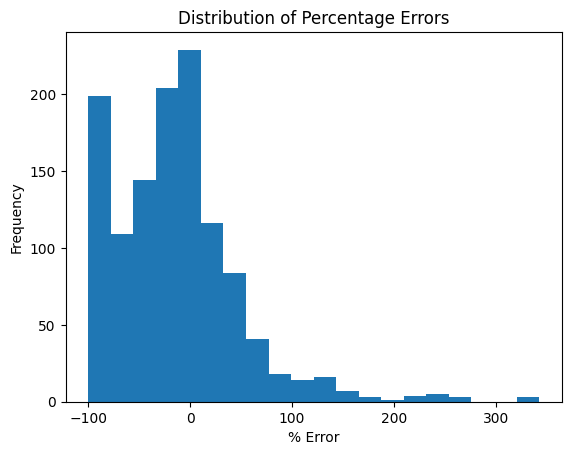


Sensitivity Analysis for Alpha:


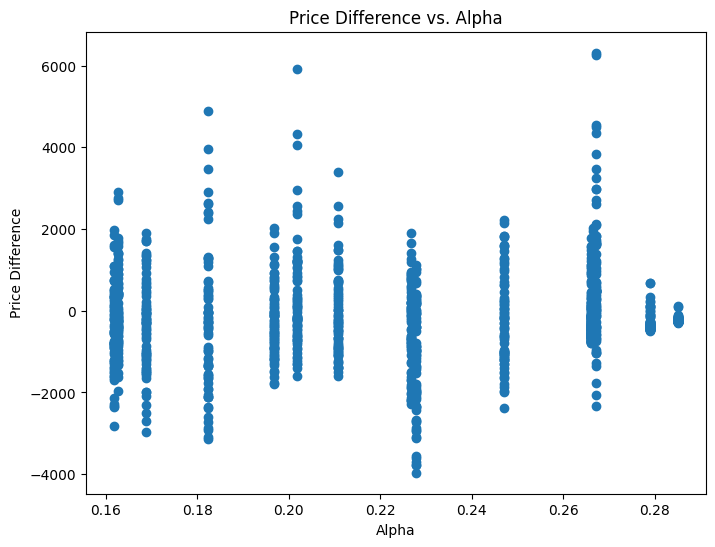


Sensitivity Analysis for Eta:


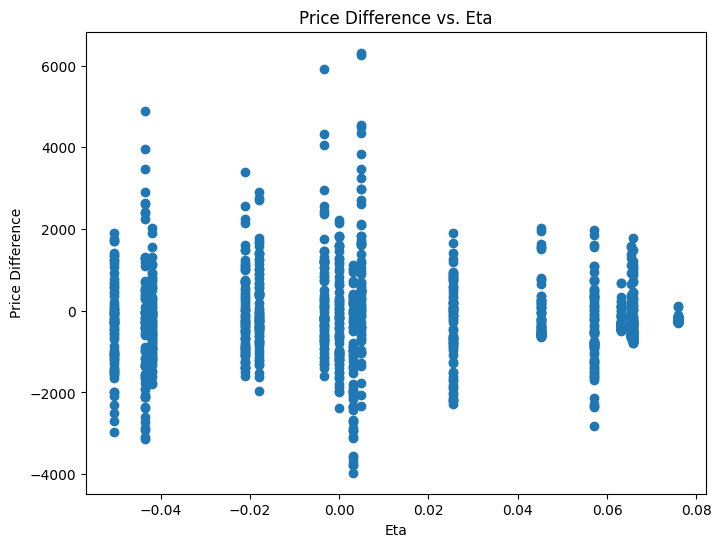


Sensitivity Analysis for Nu:


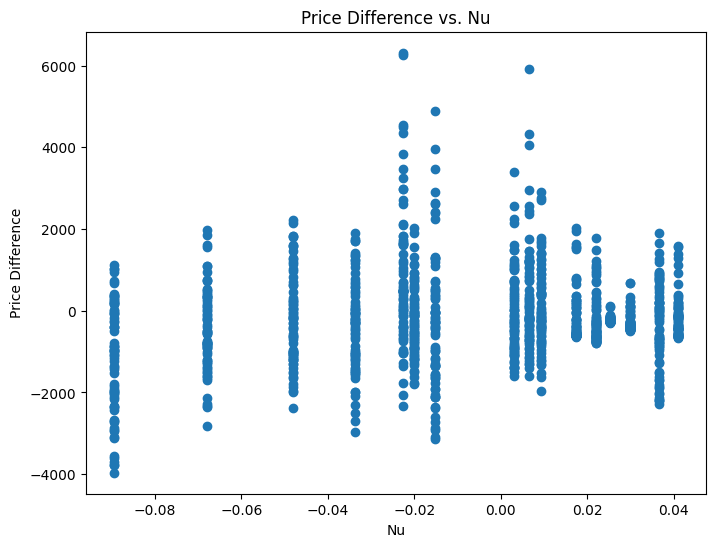


Sensitivity Analysis for Sigma_nu:


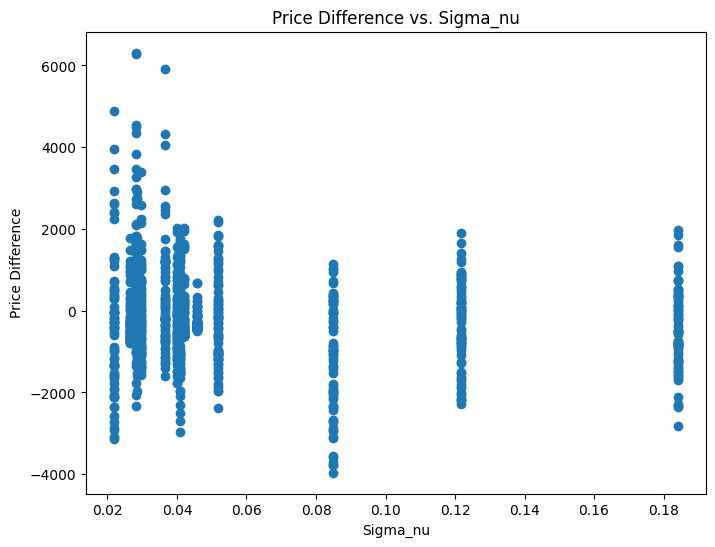


Sensitivity Analysis for Rho:


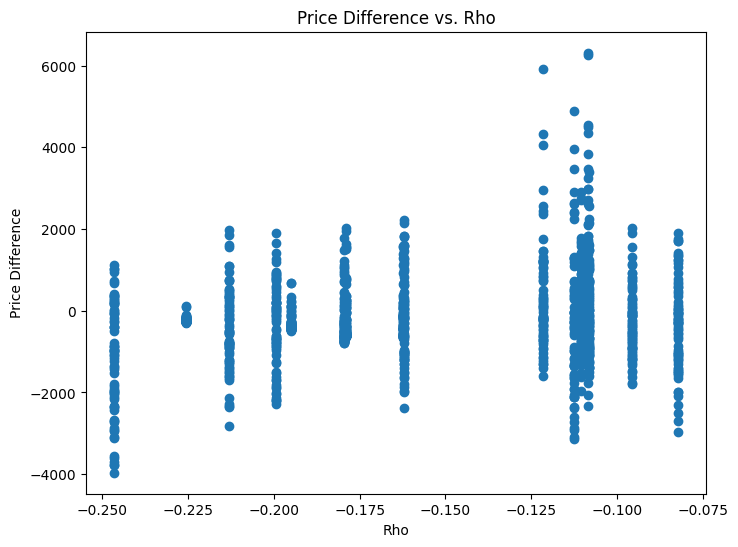

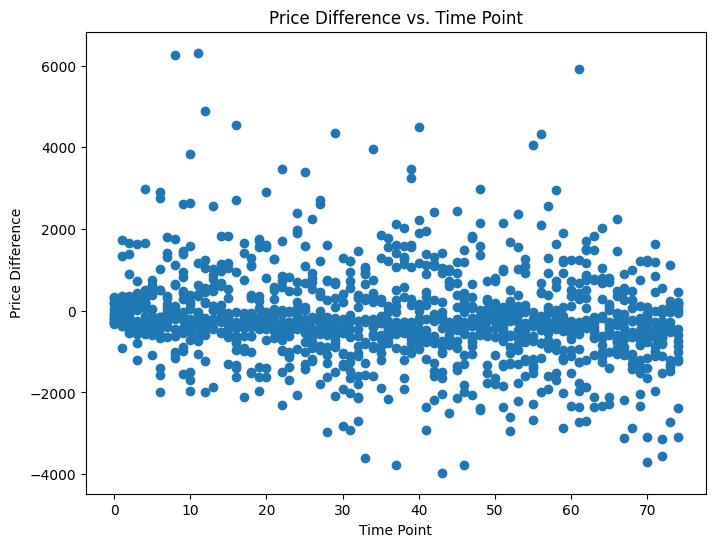

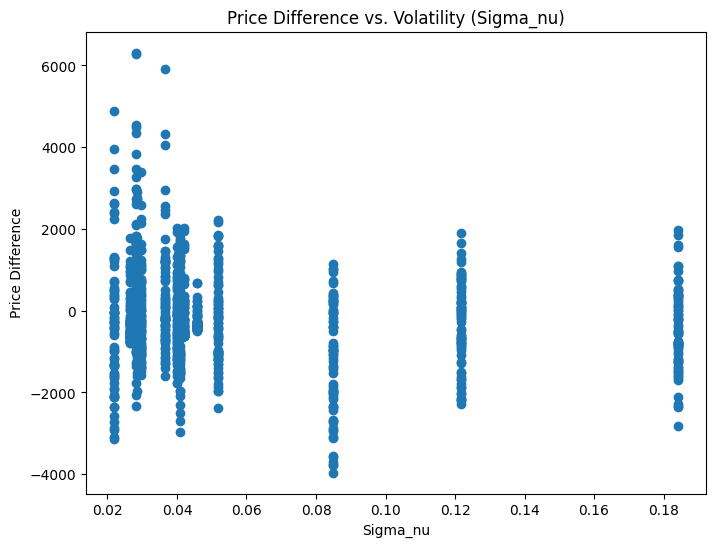

         abs_error
count  1200.000000
mean    821.069058
std     800.808895
min       1.164386
25%     274.918267
50%     574.021145
75%    1139.210027
max    6315.344857


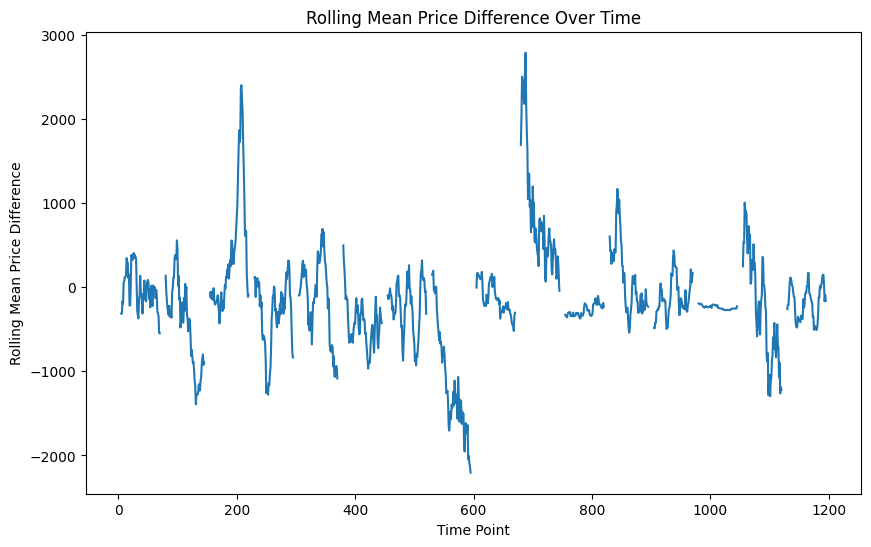

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the Excel file
df_all = pd.read_excel('heston_comparison_all_data.xlsx')

# Calculate the pricing error
df_all['Price Difference'] = df_all['Heston Price'] - df_all['Actual Price']
df_all['% Error'] = (df_all['Price Difference'] / df_all['Actual Price']) * 100

# Replace infinite values with NaN
df_all['% Error'] = df_all['% Error'].replace([np.inf, -np.inf], np.nan)


# 1. Overall Statistics
print("Overall Statistics:")
print(df_all[['Price Difference', '% Error']].describe())

# 2. Overestimation vs. Underestimation
overestimations = len(df_all[df_all['Price Difference'] > 0])
underestimations = len(df_all[df_all['Price Difference'] < 0])
print(f"\nOverestimations: {overestimations}, Underestimations: {underestimations}")

# 3. Frequency of % Error
print("\nFrequency of % Error:")
# Drop rows with NaN in '% Error' before using value_counts
print(df_all['% Error'].dropna().value_counts(bins=10))
plt.hist(df_all['% Error'].dropna(), bins=20)  # Histogram of the % Error, drop NaN for plotting
plt.xlabel('% Error')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Errors')
plt.show()


# 4. Parameter Sensitivity Analysis
parameters = ['Alpha', 'Eta', 'Nu', 'Sigma_nu', 'Rho']
for param in parameters:
    print(f"\nSensitivity Analysis for {param}:")
    plt.figure(figsize=(8, 6))
    plt.scatter(df_all[param], df_all['Price Difference'])
    plt.xlabel(param)
    plt.ylabel('Price Difference')
    plt.title(f'Price Difference vs. {param}')
    plt.show()

# 5. Time to Maturity Impact
plt.figure(figsize=(8, 6))
plt.scatter(df_all['Time Point'], df_all['Price Difference'])  # Assuming 'Time Point' represents time to maturity
plt.xlabel('Time Point')  # Replace with "Time to Maturity" if you have this column directly
plt.ylabel('Price Difference')
plt.title('Price Difference vs. Time Point')
plt.show()

# 6. Volatility Impact
plt.figure(figsize=(8, 6))
plt.scatter(df_all['Sigma_nu'], df_all['Price Difference']) #'Sigma_nu' is volatility in Heston Model
plt.xlabel('Sigma_nu') # Volatility (Sigma_nu)
plt.ylabel('Price Difference')
plt.title('Price Difference vs. Volatility (Sigma_nu)')
plt.show()

#More detailed error analysis
error_analysis_df = pd.DataFrame()
error_analysis_df['abs_error'] = np.abs(df_all['Price Difference'])

print(error_analysis_df.describe())

#Group by Test Series Index to identify mispricing patterns within the series
#print(df_all.groupby('Test Series Index')['% Error'].describe()) #Uncomment this for detailed test series wise error analysis


# 7.  Mispricing Pattern Analysis (Example: using a rolling window)
#You could replace Time Point with Time to Maturity if you have it in your dataframe
window_size = 10  # Adjust as needed
df_all['Rolling Mean Error'] = df_all.groupby('Test Series Index')['Price Difference'].rolling(window=window_size, center=True).mean().reset_index(0, drop=True)
plt.figure(figsize=(10, 6))
plt.plot(df_all['Rolling Mean Error'])
plt.xlabel('Time Point')
plt.ylabel('Rolling Mean Price Difference')
plt.title('Rolling Mean Price Difference Over Time')
plt.show()

In [ ]:
# prompt: further generate an excel sheet containing data such as mse of all parameters, mse of model, number of overestimation , underestimation, mean % error, mean absolute error, and so on and download the excel sheet with the name which is the title of this notebook

import pandas as pd
import numpy as np
import os

# Assuming df_all is your DataFrame from the previous code

# Create a dictionary to store the results
results_dict = {}

# Overall Statistics
results_dict['Overall Statistics'] = df_all[['Price Difference', '% Error']].describe().to_dict()

# Overestimation vs. Underestimation
results_dict['Overestimations'] = len(df_all[df_all['Price Difference'] > 0])
results_dict['Underestimations'] = len(df_all[df_all['Price Difference'] < 0])

# Mean Absolute Error
results_dict['Mean Absolute Error'] = np.mean(np.abs(df_all['Price Difference']))


# Mean Percentage Error (ignoring NaN values)
results_dict['Mean % Error'] = np.nanmean(df_all['% Error'])

# MSE of all parameters
mse_per_parameter = np.mean((ensemble_predictions - params_test) ** 2, axis=0)
parameter_names = ['alpha', 'eta', 'nu', 'sigma_nu', 'rho']
results_dict['MSE per Parameter'] = dict(zip(parameter_names, mse_per_parameter))

# MSE of model
results_dict['Ensemble Model MSE'] = ensemble_loss

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame([results_dict])


# Get the notebook title (replace with your actual method if needed)
notebook_title = "14 AUGUST"  # Replace with a method to get the notebook title


# Save the DataFrame to an Excel file with the notebook title
output_filename = f'{notebook_title}.xlsx'
results_df.to_excel(output_filename, index=False)

# Download the Excel file
from google.colab import files
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>